In [1]:
import operator as op
import re
from itertools import combinations, product
from functools import lru_cache
import typing as t
from collections import Counter
from io import StringIO

import numpy as np
import pandas as pd
import theano
import pymc3 as pm
import rpy2
import seaborn as sns
import matplotlib.pyplot as plt
import skbio
import editdistance
from IPython.display import display
from theano import tensor as tt
from scipy.spatial.distance import braycurtis, squareform
from scipy import stats
from skbio import diversity
from skbio.stats import composition as coda
from resample import bootstrap
from biom import load_table
from Bio import SeqIO
from fn import F

theano.config.compute_test_value = 'ignore'
sns.set(style="whitegrid", palette="pastel", color_codes=True)

%matplotlib inline
%load_ext rpy2.ipython

np.random.seed(139)

!mkdir -p figures

In [2]:
%%R

library(broom)
library(compositions)
library(dplyr)
library(ggfortify)
library(ggplot2)
library(ggtree)
library(glmnet)
library(latex2exp)
library(MASS)
library(phangorn)
library(phytools)
library(plyr)
library(reshape2)
library(sfsmisc)
library(tidyr)
library(vegan)
library(zCompositions)


set.seed(139)

R[write to console]: Loading required package: tensorA

R[write to console]: 
Attaching package: ‘tensorA’


R[write to console]: The following object is masked from ‘package:base’:

    norm


R[write to console]: Loading required package: robustbase

R[write to console]: Loading required package: bayesm

R[write to console]: Welcome to compositions, a package for compositional data analysis.
Find an intro with "? compositions"


R[write to console]: 
Attaching package: ‘compositions’


R[write to console]: The following objects are masked from ‘package:stats’:

    cor, cov, dist, var


R[write to console]: The following objects are masked from ‘package:base’:

    %*%, scale, scale.default


R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading req

Load the OTU table and subset sequence variants with more than 10 observations per sample in at least 30 (50%) samples

In [3]:
table = load_table('data/table.biom')
counts = table.matrix_data.toarray().astype(int)
taxonomy = table.metadata_to_dataframe('observation')
metadata = table.metadata_to_dataframe('sample')

In [4]:
metadata.head()

,cycle,replicate
22_1,22,1
22_2,22,2
22_3,22,3
22_4,22,4
22_5,22,5


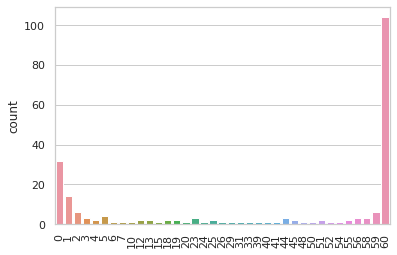

In [5]:
countplot = sns.countplot((counts > 10).sum(axis=1))
countplot.set_xticklabels(countplot.get_xticklabels(), rotation=90)
display(countplot)

In [6]:
# select ASVs with > 10 observations per sample in at least 30 samples
selected = (counts > 10).sum(axis=1) >= 30
counts_obs = counts[selected].T
taxonomy_obs = taxonomy[selected]
tips_obs = taxonomy_obs.index

# with open('data/tree.nwk') as buffer:
#     tree_sheared = skbio.read(buffer, format="newick", into=skbio.tree.TreeNode).shear(tips_obs)
#     # label internal nodes
#     tree_sheared.assign_ids()
#     for node in tree_sheared.traverse():
#         if not node.is_tip():
#             node.name = f'n{node.id}' 
# counts_obs.shape

(60, 134)

134 ASVs left. Run a Bayesian-multiplicative zero-replacement procedure with a Dirichlet prior

In [7]:
%%R -i counts_obs -o freqs_obs

freqs_obs <- counts_obs %>% cmultRepl %>% as.matrix

In [8]:
psi = coda._gram_schmidt_basis(freqs_obs.shape[1])

Here we define all vectors and matrices described in the *Mathematical formulation* subsection of the manuscript.

In [9]:
freqs_obs.shape, psi.shape

((60, 134), (133, 134))

In [10]:
# calculate balances
y_obs = np.log(freqs_obs) @ psi.T
y_obs.shape

(60, 133)

Investigate balance distribution moments to choose suitable priors for parameters $\boldsymbol{\alpha}$ and $\boldsymbol{\sigma}$

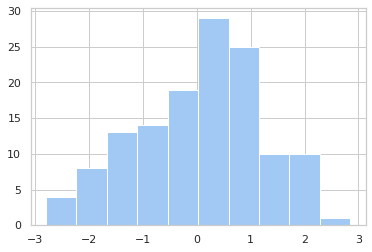

In [11]:
pd.DataFrame(y_obs).mean().hist()

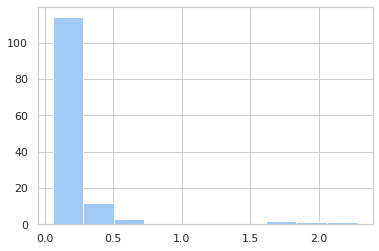

In [12]:
pd.DataFrame(y_obs).std().hist()

Define the model

$$
\boldsymbol{\hat{y}(t)} =  \left [
    \Psi \times \ln(\boldsymbol{\lambda} + 1) \cdot t
    + \boldsymbol{\alpha})
\right ]
$$

In [13]:
cycle: theano.tensor.sharedvar.TensorSharedVariable = theano.shared(metadata['cycle'].values)  # variable $t$

model = pm.Model() 

with model:
    # priors for parameters lambda, alpha and balance standard deviations
    lambda_ = pm.Beta('lambda', alpha=4.0, beta=1.0, shape=psi.shape[1])
    alpha = pm.Normal('alpha', mu=0, sd=2, shape=psi.shape[0])
    sigma = pm.HalfNormal('sigma', sd=1, shape=psi.shape[0])
    # balance expectations
    mu = (
        cycle[:, None] * pm.math.dot(psi, pm.math.log(lambda_ + 1)) +
        alpha
    )
    # we model balances as a multivariate Gaussian with a diagonal covariance matrix
    y_hat = pm.Normal('y_hat', mu=mu, sd=sigma, observed=y_obs)
    

Fit the model: 20k samples across 4 chains

In [14]:
inference_samples = 1000
tuning_samples = 500
nuts_param = {'target_accept': 0.95, 'max_treedepth': 15}
nchains = 2

with model:
    trace = pm.sample(inference_samples, chains=nchains, cores=4, 
                      tune=tuning_samples, nuts_kwargs=nuts_param, random_seed=139)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, alpha, lambda]
Sampling 2 chains: 100%|██████████| 3000/3000 [05:07<00:00,  9.77draws/s]
The number of effective samples is smaller than 25% for some parameters.


PyMC3 has a very conservative threshold (25%) for the number of effective samples (see https://discourse.pymc.io/t/the-number-of-effective-samples-is-smaller-than-25-for-some-parameters/1050 ). For comparison, Stan (another popular package for Bayesian inference) uses a threshold of 0.01%.

In [15]:
trace_summary = pm.summary(trace)

/home/anaconda/conda/envs/students2/lib/python3.6/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


In [16]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(trace_summary.round(2))

             mean    sd  mc_error  hpd_2.5  hpd_97.5    n_eff  Rhat
alpha__0    -0.42  0.20      0.00    -0.80     -0.03  1883.84  1.00
alpha__1     2.23  0.37      0.01     1.51      2.97  1346.52  1.00
alpha__2    -0.02  0.37      0.01    -0.80      0.65  1437.19  1.00
alpha__3     0.04  0.44      0.01    -0.86      0.79  1211.48  1.00
alpha__4     0.08  0.29      0.01    -0.50      0.63  1691.42  1.00
alpha__5    -2.33  0.21      0.01    -2.75     -1.90  1705.18  1.00
alpha__6    -0.18  0.30      0.01    -0.76      0.43  1359.13  1.00
alpha__7     0.92  0.40      0.01     0.20      1.73  1488.24  1.00
alpha__8    -0.12  0.21      0.00    -0.55      0.26  1521.94  1.00
alpha__9     0.39  0.18      0.01     0.04      0.72   884.40  1.00
alpha__10    0.35  0.30      0.01    -0.22      0.93  1730.37  1.00
alpha__11   -1.29  0.47      0.01    -2.26     -0.44  1528.86  1.00
alpha__12    1.06  0.24      0.01     0.56      1.45   876.59  1.00
alpha__13   -1.28  0.17      0.00    -1.59     -

All $\hat{R}$ values have converged on 1.0, which is a good indicator of parameter convergence across all 4 chains.

(<Figure size 432x6192 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd94ffbf9e8>],
       dtype=object))

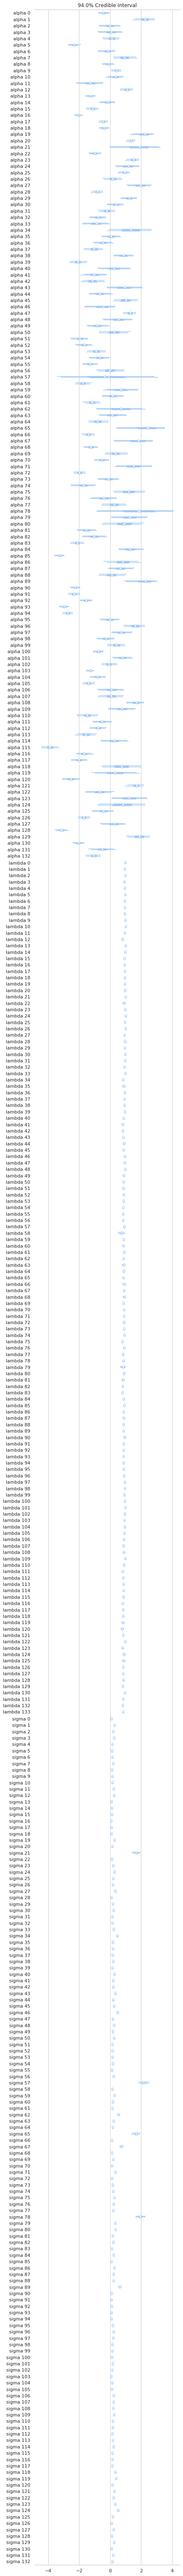

In [20]:
pm.forestplot(trace) 

![](figures/traceplot.png)

We will now take 500 samples from the posterior predictive at cycles 22-26.

In [120]:
cycle.set_value(np.arange(22, 27))
y_posterior = np.swapaxes(
    pm.sample_posterior_predictive(trace, samples=500, model=model, random_seed=139)['y_hat'],
    0, 1
)
# average across all posterior samples
y_hat_mean = np.mean(y_posterior, axis=1)
y_hat_mean.shape

100%|██████████| 500/500 [00:01<00:00, 311.17it/s]


(5, 133)

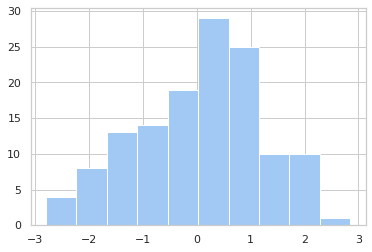

In [121]:
pd.DataFrame(y_obs).mean().hist()

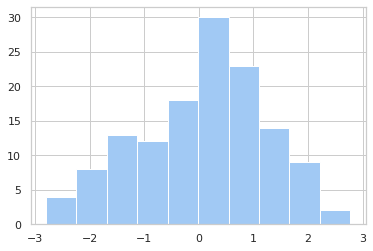

In [122]:
pd.DataFrame(y_hat_mean).mean().hist()

You can see, that the posterior distribution of balance mean values closely resembles that of observed data.

Now, let's compare phyla dynamics in observed and predicted balances

In [123]:
def summarise_phyla(phyla: pd.Series, cycle: pd.Series, frequencies: pd.DataFrame):
    return (
        F()
        # create a dataframe of frequencies with seq IDs as column names
        >> F(pd.DataFrame, columns=phyla.index) 
        # add cycle number to each sample
        >> (lambda df: pd.concat([df, cycle.rename('cycle')], axis=1))
        # calculate cycle average and transpose
        >> (lambda df: df.groupby('cycle').mean().T)
        # add phylum name to for each sequence ID
        >> (lambda df: pd.concat([df, phyla.rename('Phylum')], axis=1))
        # sum sequence frequencies within each phylum
        >> (lambda df: df.groupby('Phylum').sum())
        # reset index
        >> pd.DataFrame.reset_index
    )(frequencies)

In [124]:
# observed dynamics
phyla_obs: np.ndarray = summarise_phyla(
    taxonomy_obs['taxonomy_1'], 
    metadata.reset_index()['cycle'],
    freqs_obs
)
phyla_obs['Type'] = 'Observed'
phyla_obs

,Phylum,22,23,24,25,26,Type
0,Actinobacteria,0.030671,0.029159,0.031917,0.030549,0.033851,Observed
1,Bacteroidetes,0.228669,0.231715,0.239662,0.242519,0.264567,Observed
2,Firmicutes,0.711647,0.708961,0.697823,0.697038,0.668016,Observed
3,Proteobacteria,0.029012,0.030164,0.030598,0.029895,0.033566,Observed


In [125]:
y_mean_hat.shape, psi.shape

((5, 133), (133, 134))

In [126]:
# calculate predicted frequencies using the inverse ILR transform
freqs_hat_mean: np.ndarray = coda.closure(np.exp(y_hat_mean @ psi))

phyla_hat = summarise_phyla(
    taxonomy_obs['taxonomy_1'], 
    pd.Series(np.arange(22, 27), name='cycle'),
    freqs_hat_mean
)
phyla_hat['Type'] = 'Predicted'
phyla_hat

,Phylum,22,23,24,25,26,Type
0,Actinobacteria,0.029113,0.030155,0.030881,0.031507,0.032587,Predicted
1,Bacteroidetes,0.226266,0.233893,0.240621,0.249752,0.256328,Predicted
2,Firmicutes,0.715828,0.706319,0.697990,0.687362,0.678613,Predicted
3,Proteobacteria,0.028793,0.029632,0.030507,0.031379,0.032472,Predicted


In [127]:
phyla_dynamics = pd.concat([phyla_obs, phyla_hat])

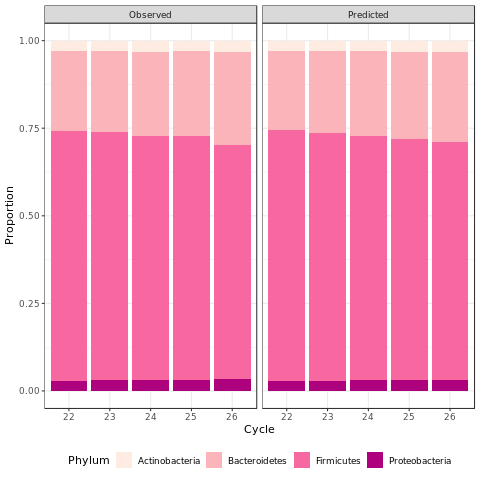

In [128]:
%%R -i phyla_dynamics

colnames(phyla_dynamics) <- gsub('X', '', colnames(phyla_dynamics))
phyla_long <- melt(phyla_dynamics, id.vars=c('Phylum', 'Type'))
phyla_long
phyla.cmp.plot <- ggplot(data=phyla_long, aes(x=variable, y=value, fill=Phylum)) +
    geom_bar(stat='identity') + 
    xlab('Cycle') +
    ylab('Proportion') +
    facet_wrap(~Type) + 
    scale_fill_brewer(palette='RdPu') +
    theme_bw() +
    theme(legend.position="bottom")

ggsave('figures/phyla_cmp_plot.png', phyla.cmp.plot, width=6, height=8, dpi=500)

phyla.cmp.plot

The model provides a decent approximation of observed dynamics. Now, let's extend the prediction to cycles 0-35

In [129]:
cycles_ext: pd.Series = pd.Series(np.arange(0, 36), name='cycle')

cycle.set_value(cycles_ext.values)


y_posterior_ext = np.swapaxes(
    pm.sample_posterior_predictive(trace, samples=100, model=model, random_seed=139)['y_hat'],
    0, 1
)
# average across all posterior samples
y_hat_mean_ext = np.mean(y_posterior_ext, axis=1)

freqs_hat_mean_ext: np.ndarray = coda.closure(np.exp(y_hat_mean_ext @ psi))
    
phyla_hat_ext: pd.DataFrame = summarise_phyla(
    taxonomy_obs['taxonomy_1'], 
    cycles_ext,
    freqs_hat_mean_ext
)

100%|██████████| 100/100 [00:00<00:00, 243.23it/s]


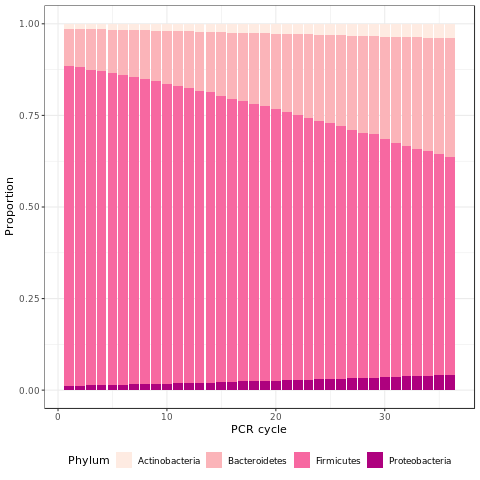

In [130]:
%%R -i phyla_hat_ext

phyla_hat_ext_long <- melt(phyla_hat_ext, id.vars='Phylum')
phyla_dynamics_ext <- ggplot(data=phyla_hat_ext_long, aes(x=as.integer(variable), y=value, fill=Phylum)) +
    geom_bar(stat='identity') + 
    xlab('PCR cycle') + 
    ylab('Proportion') +
    scale_fill_brewer(palette='RdPu') +
    theme_bw() +
    theme(legend.position="bottom")

dir.create('figures', showWarnings = FALSE)
ggsave('figures/phyla_dynamics_extended.png', dpi=500, height=8, width=6)
phyla_dynamics_ext

Calculate log-ratios of relative abundances of invidiual amplicon sequence variants 

In [131]:
def calculate_logratios(base: int, group_a: pd.DataFrame, group_b: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate log(sample_a / sample_b) for each pair sample_a, sample_b in the Cartesian
    product of group_a and group_b.
    :param base: log base
    :param group_a: a DataFrame of community compositions (relative abundances);
    one composition per row.
    :param group_b: -//-
    """
    log_base = np.log(base)
    samples_a = [np.log(row) / log_base for _, row in group_a.iterrows()]
    samples_b = [np.log(row) / log_base for _, row in group_b.iterrows()]
    comparisons = [a - b for a, b in product(samples_a, samples_b)]
    return pd.DataFrame(comparisons).reset_index(drop=True)


def logratio_correlation(n_samples: int, rng_seed: int, conf: float, ratios_a: pd.DataFrame, ratios_b: pd.DataFrame) \
        -> t.Tuple[float, float, float, float]:
    """
    1. Calcuate ASV-wise median log-ratios in ratios_a and ratios_b -> medians_a, medians_b
    2. Calculate point estimate of Pearson correlation between medians_a and medians_b
    3. Apply bootsrapping to estimate confidence intervals
    :param n_samples: bootstrap samples
    :param rng_seed: RNG seed
    :param conf: confidence level. Should be a value in (0, 1), e.g. 0.95.
    :param ratios_a: a DataFrame of element-wise log-ratios; 
    rows - samples, columns - community components
    :param ratios_b: -//-
    :return: sample Pearson correlation, 2.5 bootstrap percentile, 97.5 bootstrap percentile,
    test p-value for the no-correlation null-hypothesis
    """ 
    medians_a = ratios_a.median(0)
    medians_b = ratios_b.median(0)
    sample_corr, test_p = stats.pearsonr(medians_a, medians_b)
    boot_ci = bootstrap.bootstrap_ci(
        pd.concat([medians_a, medians_b], axis=1).values,
        lambda pairs: stats.pearsonr(*pairs.T)[0],
        b=n_samples, p=conf, boot_method='balanced', random_state=rng_seed
    )
    return (sample_corr, *boot_ci, test_p)

In [132]:
def disambiguate_names(names: pd.Series):
    """
    Disambiguate reteated names by appending a parenthesised number
    """
    return (
        names if len(names) == 1 else
        pd.Series([f'{name} ({i})' for i, name in enumerate(names, 1)], index=names.index, name=names.name)
    )

disambiguated_genera = taxonomy_obs.groupby('taxonomy_5').apply(
        lambda df: disambiguate_names(df['taxonomy_5'])
).reset_index(level=0, drop=True)

# calculate log-ratios for experimental and predicted data at cycles 22 and 26
freqs22_obs = pd.DataFrame(freqs_obs[:12], columns=taxonomy_obs.index).loc[:,disambiguated_genera.index]
freqs26_obs = pd.DataFrame(freqs_obs[-12:], columns=taxonomy_obs.index).loc[:,disambiguated_genera.index]

freqs22_hat = pd.DataFrame(
    coda.closure(np.exp(y_posterior[0] @ psi)), 
    columns=taxonomy_obs.index
).loc[:,disambiguated_genera.index]
freqs26_hat = pd.DataFrame(
    coda.closure(np.exp(y_posterior[-1] @ psi)), 
    columns=taxonomy_obs.index
).loc[:,disambiguated_genera.index]
    
logratios_obs = calculate_logratios(2, freqs22_obs, freqs26_obs)
logratios_hat = calculate_logratios(2, freqs22_hat, freqs26_hat)

# estimate correlation between experimental and predicted log-ratios
'Pearson r={:.3f}, 95% CI=({:.3f}, {:.3f}), p={:.9f}'.format(
    *logratio_correlation(1000, 139, 0.95, logratios_obs, logratios_hat)
)

'Pearson r=0.543, 95% CI=(0.524, 0.926), p=0.000000000'

In [133]:
# plot 35 vs 0 log-ratio distributions for the classified subset of ASVs

# select ASVs with classified genera
disambiguated_genera_classified = disambiguated_genera[
    ~disambiguated_genera.apply(lambda x: x.startswith('unclassified'))
]

freqs0_hat = pd.DataFrame(
    coda.closure(np.exp(y_posterior_ext[0] @ psi)), 
    columns=taxonomy_obs.index
).loc[:,disambiguated_genera_classified.index]
freqs35_hat = pd.DataFrame(
    coda.closure(np.exp(y_posterior_ext[-1] @ psi)), 
    columns=taxonomy_obs.index
).loc[:,disambiguated_genera_classified.index]

logratios_hat_ext = calculate_logratios(2, freqs35_hat, freqs0_hat)
logratio_ordering = logratios_hat_ext.median(0).sort_values().index
seq_to_phylum = taxonomy_obs.loc[logratio_ordering, 'taxonomy_1']
seq_to_genus = disambiguated_genera_classified.loc[logratio_ordering].apply(F(re.compile('[\[\]]').sub, ''))

R[write to console]: No id variables; using all as measure variables



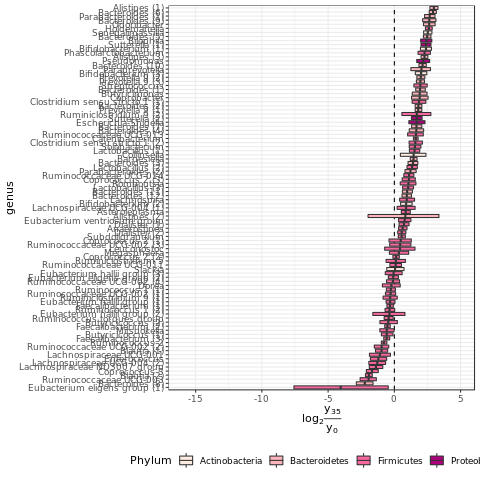

In [134]:
%%R -i logratios_hat_ext,seq_to_genus,seq_to_phylum

logratios.hat.ext.long <- melt(logratios_hat_ext)
logratios.hat.ext.long$variable <- as.character(logratios.hat.ext.long$variable)
logratios.hat.ext.long$genus <- factor(
    unname(seq_to_genus[logratios.hat.ext.long$variable]),
    levels=unname(seq_to_genus),
    ordered=TRUE
)
logratios.hat.ext.long$phylum <- seq_to_phylum[logratios.hat.ext.long$variable]

plot.logratio <- ggplot(data=logratios.hat.ext.long, aes(x=genus, y=value)) + 
    geom_hline(yintercept=0, linetype="dashed") +
    geom_boxplot(aes(fill=phylum), coef=0, outlier.shape=NA) +
    coord_flip(ylim = c(-16, 5)) +
    labs(fill='Phylum', y=TeX('$\\log_2 \\frac{y_{35}}{y_{0}}$')) +
    scale_fill_brewer(palette='RdPu') +
    theme_bw() +
    theme(legend.position='bottom')

ggsave('figures/logratio_boxplot_reduced.png', plot.logratio, width=8, height=15, dpi=500)

plot.logratio

Plot several relative abundance curves for low-abundance and high-abundance ASVs.

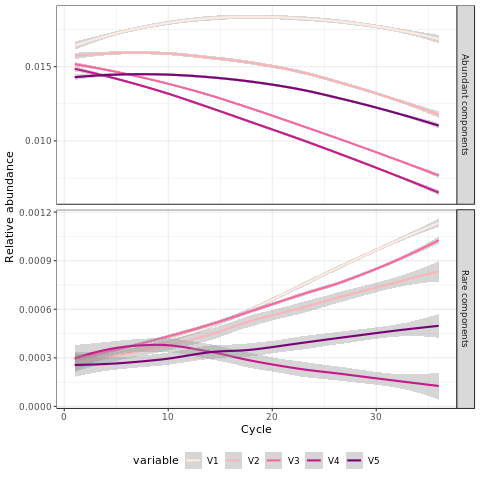

In [72]:
%%R -i freqs_hat_mean_ext,taxonomy_obs

seqs.abundant <- order(freqs_hat_mean_ext[1,], decreasing=TRUE)[14:18]
seqs.rare <- order(freqs_hat_mean_ext[1,], decreasing=FALSE)[0:5]

freqs.abundant <- freqs_hat_mean_ext[,seqs.abundant] %>% as.data.frame
freqs.abundant$cycle <- seq(1, nrow(freqs.abundant))
freqs.abundant.long <- melt(freqs.abundant, id='cycle')
freqs.abundant.long$category <- 'Abundant components'

freqs.rare <- freqs_hat_mean_ext[,seqs.rare] %>% as.data.frame
freqs.rare$cycle <- seq(1, nrow(freqs.rare))
freqs.rare.long <- melt(freqs.rare, id='cycle')
freqs.rare.long$category <- 'Rare components'

plot.logistic.curves <- ggplot(data=rbind(freqs.abundant.long, freqs.rare.long)) + 
    geom_smooth(method='loess', aes(x=cycle, y=value, color=variable)) +
    facet_grid(rows=vars(category), scales='free') +
    scale_color_brewer(palette='RdPu') +
    xlab('Cycle') +
    ylab('Relative abundance') +
    theme_bw() +
    theme(legend.position='bottom')

ggsave('figures/logistic_curves.png', plot.logistic.curves, height=8, width=6, dpi=500)

plot.logistic.curves

Run Adonis tests on weighted Unifrac, Bray-Curtis and Aitchison dissimilarities. 

1. Extract $\lambda$
2. Calculate GC-content
3. Run a Mantel test on a pairwise $\log(\lambda)$ difference matrix and pairwise edit distances 
4. Fit and test a robust linear model $\log(\lambda) \sim \log(GC) + \log({z})$

In [75]:
def extract_parameters(trace_summary: pd.DataFrame, parameter_prefix: str) -> pd.DataFrame:
    # drop index
    parameters = trace_summary.reset_index().rename({'index': 'parameter'}, axis=1)
    selected_parameters = parameters[parameters['parameter'].apply(lambda x: x.startswith(parameter_prefix))].copy()
    selected_parameters['index'] = selected_parameters['parameter'].apply(lambda x: int(x.split('_')[-1]))
    return selected_parameters.set_index('index')


def gc_content(sequence: str) -> float:
    base_counts = Counter(sequence)
    return (base_counts['G'] + base_counts['C']) / len(sequence)

In [77]:
seqmap = {seqrec.id: str(seqrec.seq) for seqrec in SeqIO.parse('data/sequences.fna', 'fasta')}

In [89]:
lambda_hat = pd.Series(extract_parameters(trace_summary, 'lambda_')['mean'].values)

alpha_hat = extract_parameters(trace_summary, 'alpha')['mean']
sigma_hat = extract_parameters(trace_summary, 'sigma')['mean']
z_hat = coda.closure(np.exp(alpha_hat @ psi))
amplicons = [seqmap[key] for key in tips_obs]
gc = pd.Series([gc_content(seq) for seq in amplicons], index=tips_obs)


	robust F-test (as if non-random weights)

data:  from rlm(formula = log(lambda) ~ log(z) + log(gc), data = model.data)
F = 39.358, p-value = 4.757e-09
alternative hypothesis: true log(z) is not equal to 0


	robust F-test (as if non-random weights)

data:  from rlm(formula = log(lambda) ~ log(z) + log(gc), data = model.data)
F = 2.6318, p-value = 0.1071
alternative hypothesis: true log(gc) is not equal to 0


Call: rlm(formula = log(lambda) ~ log(z) + log(gc), data = model.data)
Residuals:
       Min         1Q     Median         3Q        Max 
-2.050e-01 -3.403e-02  5.178e-07  3.234e-02  1.040e-01 

Coefficients:
            Value   Std. Error t value
(Intercept) -0.3239  0.0492    -6.5799
log(z)      -0.0224  0.0036    -6.2084
log(gc)     -0.1190  0.0727    -1.6378

Residual standard error: 0.04834 on 131 degrees of freedom

	Pearson's product-moment correlation

data:  log(model.data$lambda) and log(model.data$z)
t = -6.1688, df = 132, p-value = 7.844e-09
alternative hypothesis: t

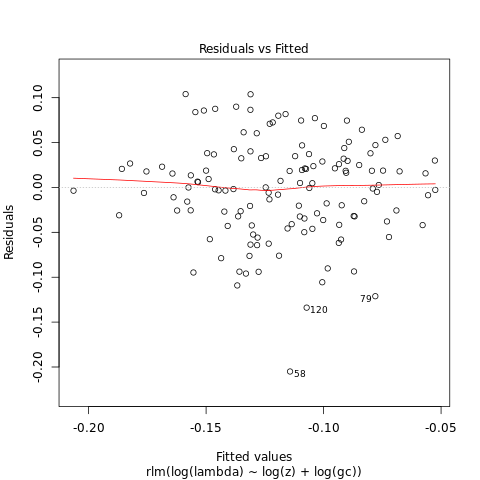

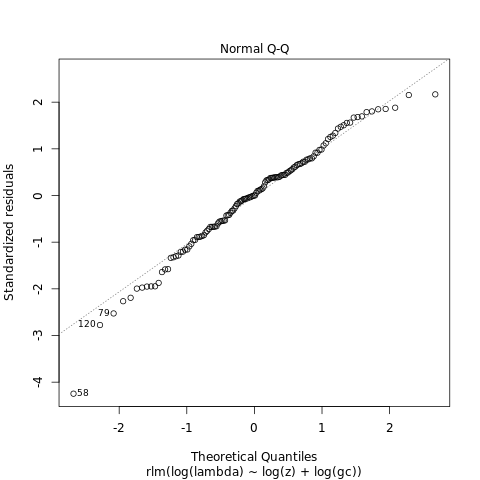

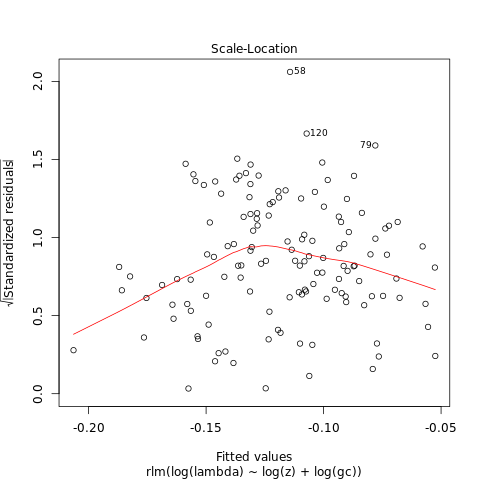

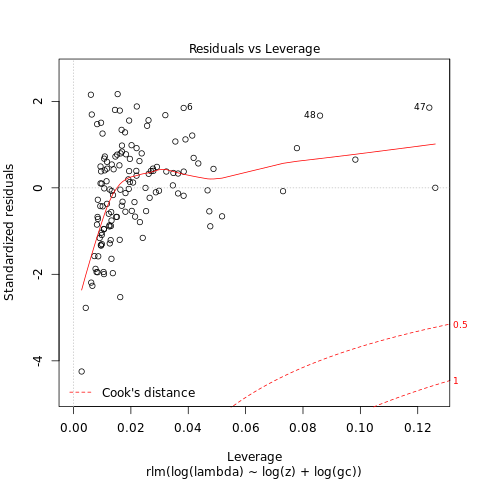

In [135]:
%%R -i lambda_hat,z_hat,gc

model.data <- data.frame(
    lambda=lambda_hat,
    z=z_hat,
    gc=gc
)

efficiency.fit <- rlm(data=model.data, log(lambda) ~ log(z) + log(gc))
print(f.robftest(efficiency.fit, var='log(z)'))
print(f.robftest(efficiency.fit, var='log(gc)'))

print(summary(efficiency.fit))
print(cor.test(log(model.data$lambda), log(model.data$z)))

plot(efficiency.fit)

Simulate the data to verify that significant correlation between $z\prime$ and $\lambda$ is not merely an artifact of the inference procedure

In [109]:
def simulate_data(cycles: np.ndarray, psi, lambda_, alpha, sigma):
    """
    :param cycles: cycle numbers
    :param psi: an ILR contrast matrix
    :param lambda_rv: a Callable taking a positive integer $n$ and 
    returning a numpy array of $n$ elements
    :param alpha_rv: -//-
    :param sigma_rv: -//-
    """    
    mu = (psi @ np.log(lambda_+1)) * cycles[:, None] + alpha[None,:]
    return stats.norm.rvs(loc=mu, scale=sigma)


In [113]:
y_sim = simulate_data(
    metadata['cycle'].values, psi,
    np.random.permutation(lambda_hat), alpha_hat, sigma_hat
)

cycle.set_value(metadata['cycle'].values)

with pm.Model() as model_sim:
    lambda_ = pm.Beta('lambda', alpha=4.0, beta=1.0, shape=psi.shape[1])
    alpha = pm.Normal('alpha', mu=0, sd=2, shape=psi.shape[0])
    sigma = pm.HalfNormal('sigma', sd=1, shape=psi.shape[0])
    mu = (
        cycle[:, None] * pm.math.dot(psi, pm.math.log(lambda_ + 1)) +
        alpha
    )
    y_hat = pm.Normal('y_hat', mu=mu, sd=sigma, observed=y_sim)
    trace_sim = pm.sample(
        1000, chains=nchains, cores=2, tune=500, nuts_kwargs=nuts_param, random_seed=139
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, alpha, lambda]
Sampling 2 chains: 100%|██████████| 3000/3000 [05:29<00:00,  9.10draws/s]


In [115]:
trace_sim_summary = pm.summary(trace_sim)

lambda_hat_sim = extract_parameters(trace_sim_summary, 'lambda_')['mean'].values
zprime_hat_sim = coda.closure(
    np.exp((extract_parameters(trace_sim_summary, 'alpha')['mean']).values @ psi)
)


	Pearson's product-moment correlation

data:  log(model.data.sim$lambda) and log(model.data.sim$zprime)
t = 0.765, df = 132, p-value = 0.4456
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1043265  0.2333961
sample estimates:
       cor 
0.06643732 



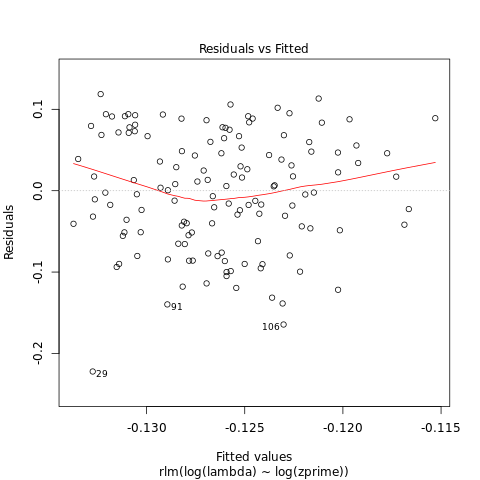

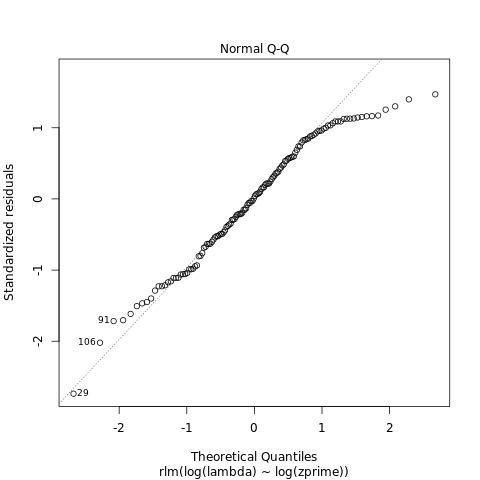

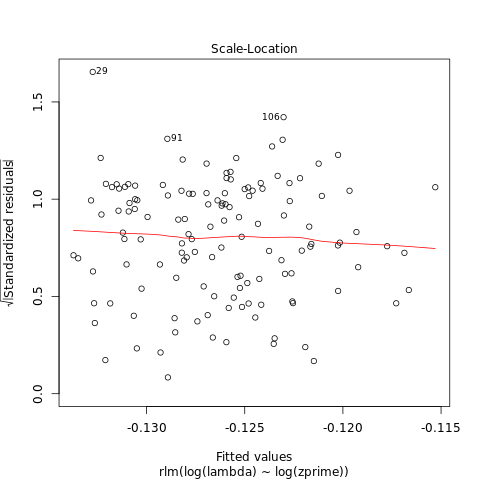

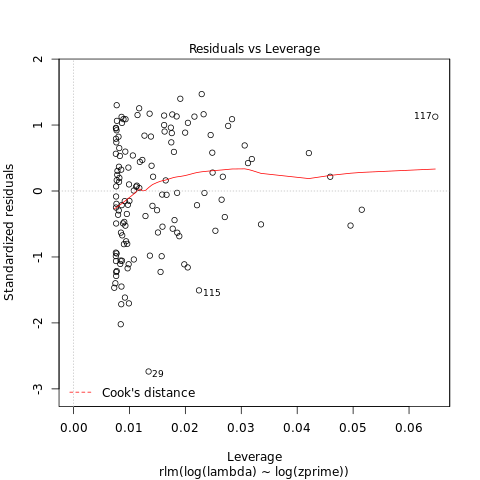

In [116]:
%%R -i lambda_hat_sim,zprime_hat_sim

model.data.sim <- data.frame(
    lambda=lambda_hat_sim,
    zprime=zprime_hat_sim
)


efficiency.fit.sim <- rlm(data=model.data.sim, log(lambda) ~ log(zprime))
print(cor.test(log(model.data.sim$lambda), log(model.data.sim$zprime)))

plot(efficiency.fit.sim)

In [118]:
levenstein = squareform(
    [editdistance.eval(a, b) for a, b in combinations(amplicons, 2)]
)

In [119]:
%%R -i levenstein

mantel(
    as.dist(levenstein),
    abs(outer(log(lambda_hat), log(lambda_hat), '-')),
    method='pearson',
    permutations=9999
)


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = as.dist(levenstein), ydis = abs(outer(log(lambda_hat),      log(lambda_hat), "-")), method = "pearson", permutations = 9999) 

Mantel statistic r: 0.177 
      Significance: 2e-04 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0514 0.0677 0.0809 0.0950 
Permutation: free
Number of permutations: 9999

